In [1]:
import random
import numpy as np

random.seed(6)  # Set the seed for Python's random module
np.random.seed(11)  # Set the seed for numpy's random module

In [2]:
from cabm import cabm_agent

In [3]:
model = cabm_agent.ConsumerModel(1, "config.toml", enable_ads=True)

/Users/michael/Documents/github/consumer-abm/cabm/cabm_helpers/ad_calendar.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/Users/michael/Documents/github/consumer-abm/cabm/cabm_helpers/ad_calendar.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '133333.33' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[week, channel] = round(
/Users/michael/Documents/github/consumer-abm/cabm/cabm_helpers/ad_calendar.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set 

In [4]:
for i in range(30):
    model.step()

/Users/michael/Documents/github/consumer-abm/cabm/cabm_helpers/ad_helpers.py:145: UserWarning: WARNING: YOU ARE USING A MODIFIED PURCH PROB GETTER
  warnings.warn("WARNING: YOU ARE USING A MODIFIED PURCH PROB GETTER")


In [5]:
model_df = model.datacollector.get_model_vars_dataframe()

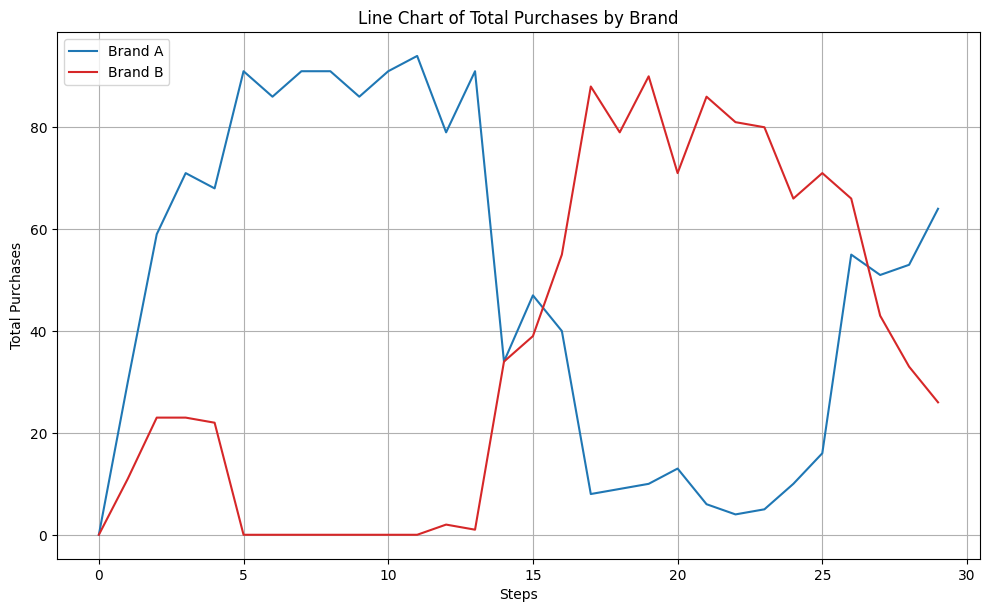

In [6]:
import matplotlib.pyplot as plt

# Extract purchases by brand
model_df['Total_Purchases_A'] = model_df['Total_Purchases'].apply(lambda x: x['A'])
model_df['Total_Purchases_B'] = model_df['Total_Purchases'].apply(lambda x: x['B'])

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_ylabel('Total Purchases')
ax1.set_xlabel('Steps')

# Plot total purchases for brand A
color = 'tab:blue'
ax1.plot(model_df['Total_Purchases_A'], color=color, label='Brand A')

# Plot total purchases for brand B
color = 'tab:red'
ax1.plot(model_df['Total_Purchases_B'], color=color, label='Brand B')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Line Chart of Total Purchases by Brand')
plt.grid(True)
plt.legend(loc='upper left')  # Add legend to the plot
plt.show()

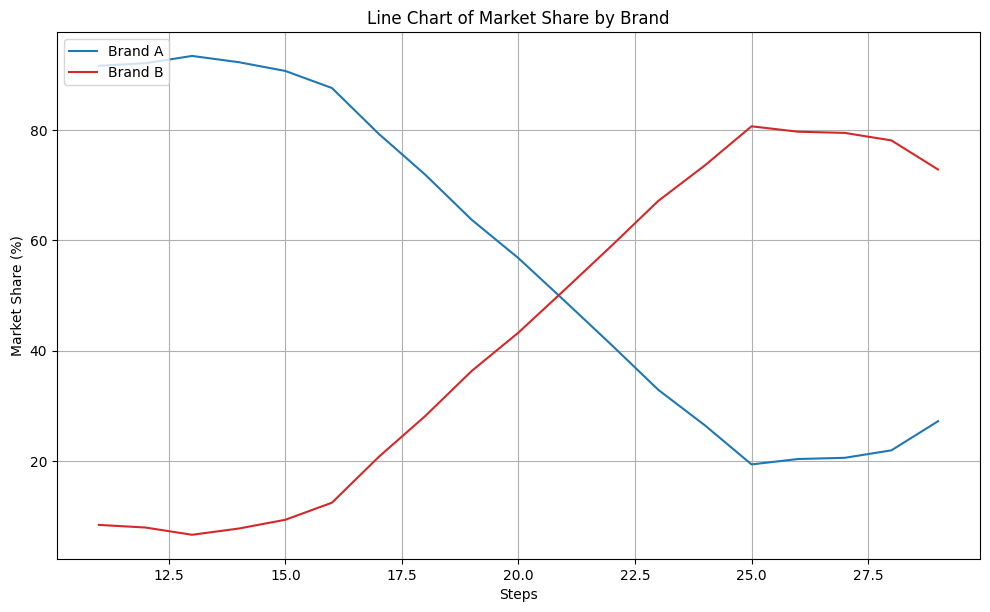

In [7]:

# Compute the monthly average for each brand
model_df['Monthly_Average_A'] = model_df['Total_Purchases_A'].rolling(window=12).mean()
model_df['Monthly_Average_B'] = model_df['Total_Purchases_B'].rolling(window=12).mean()

# Compute the total monthly average
model_df['Total_Monthly_Average'] = model_df['Monthly_Average_A'] + model_df['Monthly_Average_B']

# Compute the market share percentage for each brand
model_df['Market_Share_A'] = (model_df['Monthly_Average_A'] / model_df['Total_Monthly_Average']) * 100
model_df['Market_Share_B'] = (model_df['Monthly_Average_B'] / model_df['Total_Monthly_Average']) * 100

fig, ax2 = plt.subplots(figsize=(10,6))
ax2.set_ylabel('Market Share (%)')
ax2.set_xlabel('Steps')

# Plot market share for brand A
color = 'tab:blue'
ax2.plot(model_df['Market_Share_A'], color=color, label='Brand A')

# Plot market share for brand B
color = 'tab:red'
ax2.plot(model_df['Market_Share_B'], color=color, label='Brand B')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Line Chart of Market Share by Brand')
plt.grid(True)
plt.legend(loc='upper left')  # Add legend to the plot
plt.show()



In [10]:
agent_summary_df = model.datacollector.get_agent_vars_dataframe()

In [11]:
def check_multiple_purchases(df):
    # Define a function to check if more than one value in the dictionary is greater than 0
    def more_than_one_purchase(purchases):
        return sum(value > 0 for value in purchases.values()) > 1

    # Apply the function to the 'Purchased_This_Step' column
    multiple_purchases = df['Purchased_This_Step'].apply(more_than_one_purchase)

    # Return True if there are any cases of multiple purchases, False otherwise
    return any(multiple_purchases)

# Usage:
print(check_multiple_purchases(agent_summary_df))

False


In [12]:
def count_letter_changes(series):
    # Compute the difference between consecutive letters
    letter_changes = series != series.shift()

    # Ignore the first value
    letter_changes = letter_changes.iloc[1:]

    # Sum the letter_changes series to get the number of letter changes
    change_count = letter_changes.sum()

    return change_count

In [13]:
letter_change_counts = [count_letter_changes(agent_summary_df.xs(agent_id, level='AgentID')['Brand_Choice']) for agent_id in agent_summary_df.index.get_level_values('AgentID').unique()]


In [14]:
sum(letter_change_counts)

618

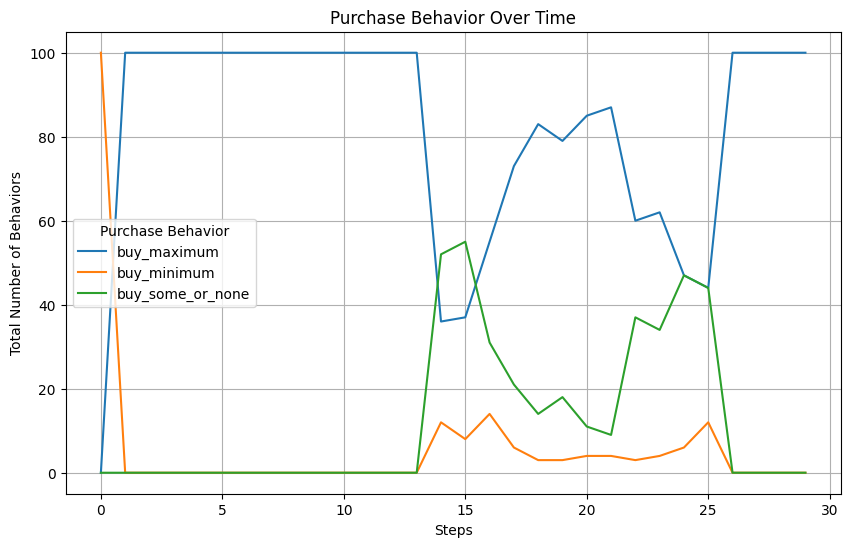

In [15]:
# Group by 'Step' and 'Purchase_Behavior' and count the occurrences
behavior_counts = agent_summary_df.groupby(['Step', 'Purchase_Behavior']).size().unstack(fill_value=0)

# Plot the behaviors over time
plt.figure(figsize=(10,6))
for behavior in behavior_counts.columns:
    plt.plot(behavior_counts.index, behavior_counts[behavior], label=behavior)

plt.title('Purchase Behavior Over Time')
plt.xlabel('Steps')
plt.ylabel('Total Number of Behaviors')
plt.legend(title='Purchase Behavior')
plt.grid(True)
plt.show()

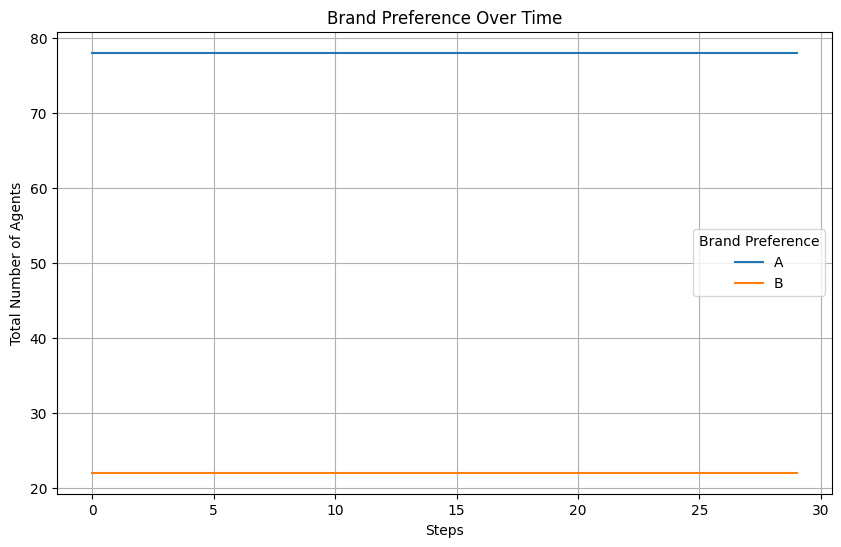

In [16]:
# Group by 'Step' and 'Brand_Preference' and count the occurrences
preference_counts = agent_summary_df.groupby(['Step', 'Brand_Preference']).size().unstack(fill_value=0)

# Plot the brand preferences over time
plt.figure(figsize=(10,6))
for preference in preference_counts.columns:
    plt.plot(preference_counts.index, preference_counts[preference], label=preference)

plt.title('Brand Preference Over Time')
plt.xlabel('Steps')
plt.ylabel('Total Number of Agents')
plt.legend(title='Brand Preference')
plt.grid(True)
plt.show()


In [17]:
agent_summary_df.xs(0, level='Step')['Purchase_Probabilities']

AgentID
0     {'A': 0.99, 'B': 0.010000000000000009}
1     {'A': 0.99, 'B': 0.010000000000000009}
2     {'A': 0.99, 'B': 0.010000000000000009}
3     {'A': 0.99, 'B': 0.010000000000000009}
4     {'A': 0.010000000000000009, 'B': 0.99}
                       ...                  
95    {'A': 0.99, 'B': 0.010000000000000009}
96    {'A': 0.99, 'B': 0.010000000000000009}
97    {'A': 0.99, 'B': 0.010000000000000009}
98    {'A': 0.99, 'B': 0.010000000000000009}
99    {'A': 0.99, 'B': 0.010000000000000009}
Name: Purchase_Probabilities, Length: 100, dtype: object